<a href="https://colab.research.google.com/github/motho17/U-SAM-hybrid-model/blob/main/deeplabV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Implementation of DeepLabV3**
DeepLabV3 experiment was done using a pretrained model with imagenet weights and resnet101 as the encoder.The code implementation is as below

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Get the data

In [2]:
!unzip '/content/drive/MyDrive/BraTs (1).zip' -d '/content/BraTs2020'

Archive:  /content/drive/MyDrive/BraTs (1).zip


In [ ]:
from glob import glob
import os
import numpy as np

imgs_dir='/content/BraTs2020/content/BraTs'
all_dirs = glob (f'{imgs_dir}/*')
all_dirs = all_dirs
# print(len(all_dirs))
all_dirs.sort()
# a = glob('/Users/jojo/Downloads/content/BraTs')
# print(a[0:10])

#split the data into training and validation data
def shuffle_split (all_dirs, val_pct = 0.19,train_pct = 0.8, seed = 99):
    """ shuffling dataset with random state and split to train and valid """
    n_train = int (len (all_dirs) * train_pct)
    n_val = int (len (all_dirs) * val_pct)+n_train

    np.random.seed (seed)
    idx = np.random.permutation (len (all_dirs))
    all_dirs = np.array (all_dirs) [idx]
#     return all_dirs [n_val:], all_dirs [:n_val]

# train_dirs, valid_dirs = shuffle_split (all_dirs, seed = 1)
# print(len(valid_dirs)), print(len(train_dirs))

    return all_dirs [:n_train], all_dirs [n_train:n_val],all_dirs [n_val:]

train_dirs, valid_dirs,test_dirs = shuffle_split (all_dirs, seed = 1)
print(len(train_dirs))
print(len(valid_dirs))
print(len(test_dirs))


40611
9645
508


# **Data class**
This class contains all the preprocessing steps including normalization,image resizing and augmentation.

In [ ]:
from glob import glob
import os
import numpy as np
import torch
import albumentations as A
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#data preprocessing class
#@title brats 8
class BratsDataset (Dataset):
  def __init__ (self, img_dirs, modality_types, transform = None):
      self.img_dirs = img_dirs
      self.transform = transform

  def __len__ (self):
      return len (self.img_dirs)

  def __getitem__ (self, index):
      imgs_path = self.img_dirs [index]
      image = self.concat_imgs (imgs_path)
      mask = np.array (Image.open (f'{imgs_path}/seg.jpg'))
      mask = (mask / 255 * 4).round ()
      mask = self.preprocess_mask_labels(mask)

      image = image.transpose(2, 1, 0)  # (B, H, W, C) to (B, C, H, W)
      mask = mask.transpose(2, 1, 0)  # (C, H, W) to (B, C, H, W)
      # print(image.shape)
      # print(mask.shape)


      if self.transform is not None:
          augmented = self.transform(image = image, mask = mask)
          image = augmented ['image']
          mask = augmented ['mask']
      image = image.permute(0,1,2)  # (B, H, W, C) to (B, C, H, W)
      mask = mask.permute(2, 0, 1)  # (C, H, W) to (B, C, H, W)
      # print(image.shape)
      # print(mask.shape)
      bboxes = self.get_bounding_box(mask)


      # return image.astype(float), mask.astype(float),bboxes
      # return image.float(), mask.float(),bboxes
      # return image.astype(np.float), mask.astype(np.float),bboxes

      # mask = mask.to(device=DEVICE)
      # image = image.to(device=DEVICE)

      return image.float(),mask.float()


  def concat_imgs (self, path: str):
      types = []
      for modality_type in modality_types:
          img = np.array (Image.open (f'{path}/{modality_type}.jpg'))
          img = self.normalize(img)
          types.append (img)
#         cat_img = np.concatenate (types, axis = -1)

      return np.array(types)
  def get_bounding_box(self, mask):
    ground_truth_map = mask[0]# Extract the first channel of the mask

    # Find the indices of non-zero elements in the ground truth map
    y_indices, x_indices = np.where(ground_truth_map > 0)

    # Calculate the minimum and maximum values for x and y coordinates
    try:
      x_min = np.min(x_indices)
      y_min = np.min(y_indices)
      x_max = np.max(x_indices)
      y_max = np.max(y_indices)

    except ValueError:
      x_min = 0
      y_min = 0
      x_max = 0
      y_max = 0
    bboxes = np.array([x_min, y_min, x_max, y_max])

    return bboxes

  def preprocess_mask_labels(self, mask: np.ndarray):
      mask_WT = np.zeros(mask.shape)
      mask_WT[mask == 2] = 1

      mask_TC = np.zeros(mask.shape)
      mask_TC[mask == 1] = 1

      mask_ET = np.zeros(mask.shape)
      mask_ET[mask == 3] = 1

      mask_BG = np.zeros(mask.shape)
      mask_BG[mask == 0] = 1

      mask = np.stack([mask_WT, mask_TC, mask_ET])#, mask_BG
      # mask = np.moveaxis(mask, (0, 1, 2), (0, 2, 1))
      return mask

  def normalize(self, data: np.ndarray):
      data_min = np.min(data)
      if np.max(data) == 0:
          return data
      if (np.max(data) - data_min) == 0:
          return data / data_min

      return (data - data_min) / (np.max(data) - data_min)


modality_types = ['flair', 't1', 't1ce']#,'t2'

trn_tfms = A.Compose([
    A.Resize(height=256, width=256),
    A.Resize(height=256, width=256),
    A.Rotate (limit = 35, p = 1.0),
    A.HorizontalFlip (p = 0.5),
    A.VerticalFlip (p = 0.1),
    ToTensorV2(),
])

val_tfms = A.Compose([
    A.Resize(height=256, width=256),
    ToTensorV2(),
])


Data Loader

In [ ]:

train_ds = BratsDataset(train_dirs, modality_types,transform = trn_tfms)
train_dl = DataLoader(train_ds, batch_size = 32, shuffle = False, num_workers = 4, pin_memory = True)

valid_ds = BratsDataset(valid_dirs, modality_types,transform = val_tfms)
valid_dl = DataLoader(valid_ds, batch_size = 16, shuffle = False, num_workers = 2, pin_memory = True)


test_ds = BratsDataset(test_dirs, modality_types,transform = val_tfms)
test_dl = DataLoader(test_ds, batch_size = 1, shuffle = False, num_workers = 2, pin_memory = True)

In [ ]:
# from segment_anything.utils.transforms import ResizeLongestSide
import matplotlib.patches as patches
#confirm that the data loader is working as expected
for images,masks in train_dl:
   print(f"{images.shape=}, {masks.shape=}")
   val, counts = np.unique(masks, return_counts=True)
   if(1 - (counts[0]/counts.sum())) > 0.01:
    print('yes')
   else:
    print('no')

   break



images.shape=torch.Size([32, 3, 256, 256]), masks.shape=torch.Size([32, 3, 256, 256])
no


In [ ]:
!pip install segmentation-models-pytorch==0.2.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 25.1 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12401 sha256=543fa0408046044192dca807721c03d6f4cdbd703d1a4da363a1fc9dd24544f1
  Stored in directory: /root/.cache/pip/wheels/61/3a/b0/0b4c443c380bd934701b0a25e4aed76479e4fcaf1a6f955664
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=94d361abd57d68b1f211b4b80cae1c2e5dee39a0afa06f038597e6cb72827ede
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


## Training the model

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import os
import albumentations as A
join = os.path.join
from tqdm import tqdm
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
import tensorflow as tf
import keras
from keras import backend as K
from torch.optim import Adam

from typing import Tuple
from glob import glob
import tensorflow as tf
import torch.nn as nn
import albumentations as album
import segmentation_models_pytorch as smp
import time

import matplotlib.patches as patches

# device = torch.device("cpu")
TRAINING = True
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = 3
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=CLASSES,
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
# model.to(device =DEVICE )
# batch_size = 4
IMAGE_SIZE = 256
num_class = 3
TRAINING = True
EPOCHS = 50
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=num_class)
# define loss function
loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.00001),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# load best saved model checkpoint from previous commit (if present)
if os.path.exists('/content/drive/MyDrive/SAM2/deeplab2_checkpoint/best_model.pth'):
    model = torch.load('/content/drive/MyDrive/SAM2/deeplab2_checkpoint/best_model.pth', map_location=DEVICE)
# checkpoint_filepath = '/Users/jojo/Documents/U-SAM-hybrid-model/deeplabv3/checkpoint/'
# checkpoint = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     monitor='loss',
#     save_best_only = True
#     )
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)





In [ ]:
model.eval()
if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_dl)
        valid_logs = valid_epoch.run(valid_dl)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        # if best_loss < valid_logs['dice_loss']:
        #   best_loss = valid_logs['dice_loss']
        #   torch.save(model, './best_model.pth')
        #   print('Model saved!')
        if best_iou_score < valid_logs['iou_score']:
          best_iou_score = valid_logs['iou_score']
          torch.save(model, './best_model.pth')
          print('Model saved!')



Epoch: 0
valid: 100%|██████████| 603/603 [00:39<00:00, 15.26it/s, dice_loss - 0.935, iou_score - 0.2154]
Model saved!

Epoch: 1
valid: 100%|██████████| 603/603 [00:39<00:00, 15.22it/s, dice_loss - 0.7282, iou_score - 0.3573]
Model saved!

Epoch: 2
valid: 100%|██████████| 603/603 [00:39<00:00, 15.24it/s, dice_loss - 0.5151, iou_score - 0.4422]
Model saved!

Epoch: 3
valid: 100%|██████████| 603/603 [00:39<00:00, 15.16it/s, dice_loss - 0.3583, iou_score - 0.569]
Model saved!

Epoch: 4
valid: 100%|██████████| 603/603 [00:39<00:00, 15.25it/s, dice_loss - 0.3011, iou_score - 0.6013]
Model saved!

Epoch: 5
valid: 100%|██████████| 603/603 [00:39<00:00, 15.22it/s, dice_loss - 0.2665, iou_score - 0.6225]
Model saved!

Epoch: 6
valid: 100%|██████████| 603/603 [00:39<00:00, 15.32it/s, dice_loss - 0.2469, iou_score - 0.6375]
Model saved!

Epoch: 7
valid: 100%|██████████| 603/603 [00:39<00:00, 15.21it/s, dice_loss - 0.2325, iou_score - 0.6496]
Model saved!

Epoch: 8
valid: 100%|██████████| 603/603 

In [ ]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(valid_dl)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid: 100%|██████████| 603/603 [00:40<00:00, 15.01it/s, dice_loss - 0.1377, iou_score - 0.7651]
Evaluation on Test Data: 
Mean IoU Score: 0.7651
Mean Dice Loss: 0.1377


In [ ]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

test_logs = test_epoch.run(test_dl)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {test_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {test_logs['dice_loss']:.4f}")

valid: 100%|██████████| 508/508 [00:10<00:00, 49.97it/s, dice_loss - 0.1419, iou_score - 0.8145]
Evaluation on Test Data: 
Mean IoU Score: 0.8145
Mean Dice Loss: 0.1419


In [ ]:
train_logs_list
losses = []
for i in range(len(train_logs_list)):
  first_key,first_value = list(train_logs_list[i].items())[0]
  losses.append(first_value)


In [ ]:
losses

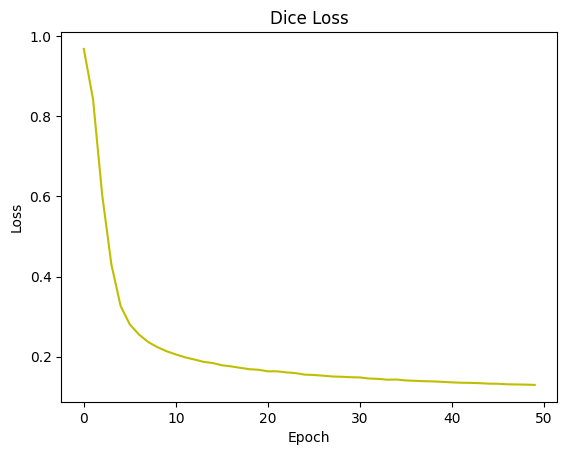

In [ ]:
work_dir = './content/drive/MyDrive/SAM'
task_name = 'Deeplab'
model_save_path = join(work_dir, task_name)
# plot loss
plt.plot(losses,'y')
plt.title('Dice Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show() # comment this line if you are running on a server
# plt.savefig(join(model_save_path, 'train_loss.png'))
plt.close()

In [ ]:
import pandas as pd

train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
dice_loss,0.968253,0.842740,0.603130,0.429656,0.326591,0.280684,0.255355,0.236791,0.223993,0.213773,...,0.136158,0.135258,0.134866,0.134157,0.132942,0.132704,0.131343,0.130939,0.130594,0.129769
iou_score,0.091909,0.278423,0.400762,0.499463,0.574339,0.605603,0.624655,0.641257,0.653288,0.663741,...,0.764304,0.765662,0.766207,0.767247,0.769145,0.769401,0.771500,0.772110,0.772586,0.773879


In [ ]:
from google.colab import files
valid_logs_df.to_csv('valid_logsdeep_df.csv', encoding = 'utf-8-sig')
files.download('valid_logsdeep_df.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
train_logs_df.to_csv('train_logsdeep_df.csv', encoding = 'utf-8-sig')
files.download('train_logsdeep_df.csv')





<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Plotting the metrics curves.

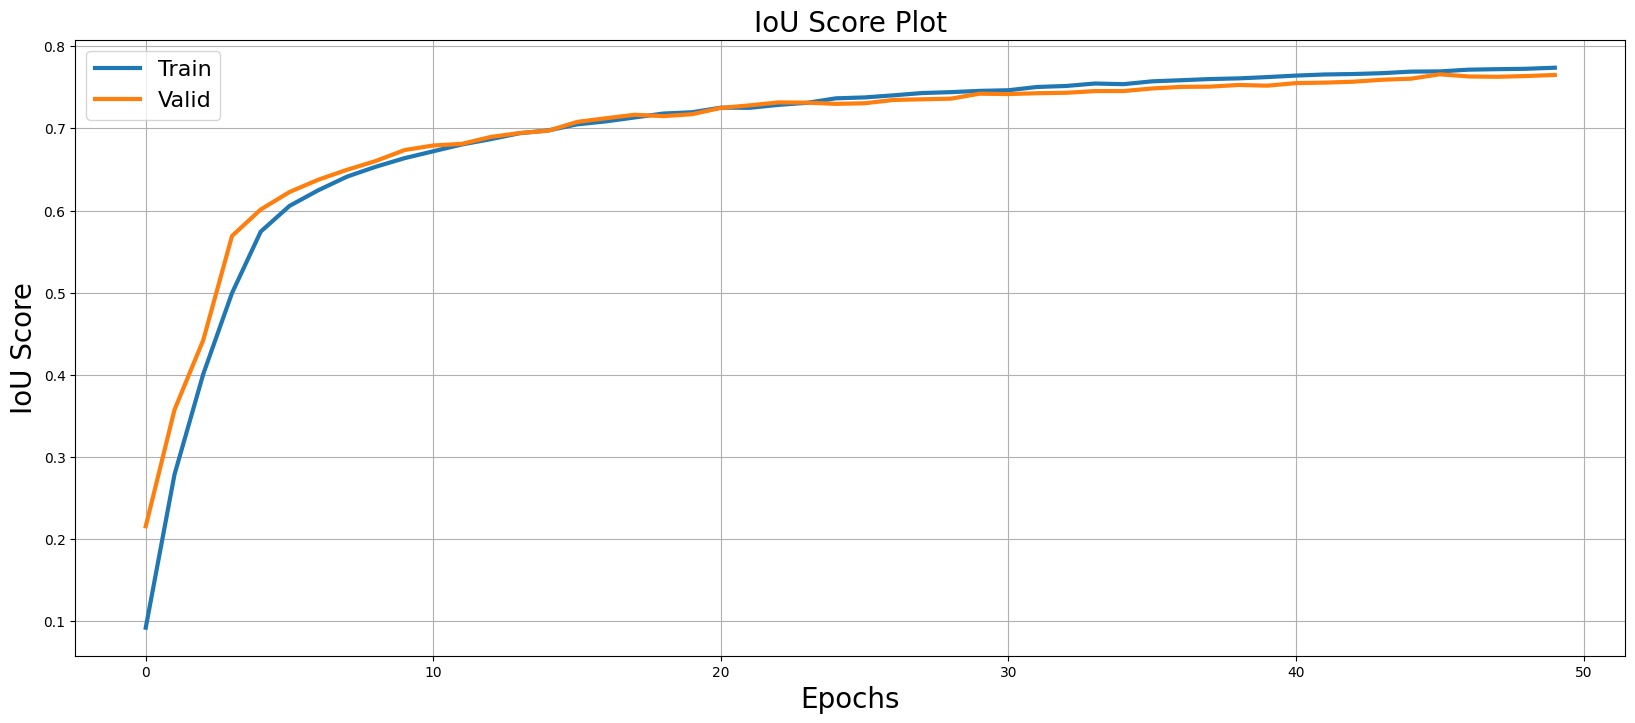

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

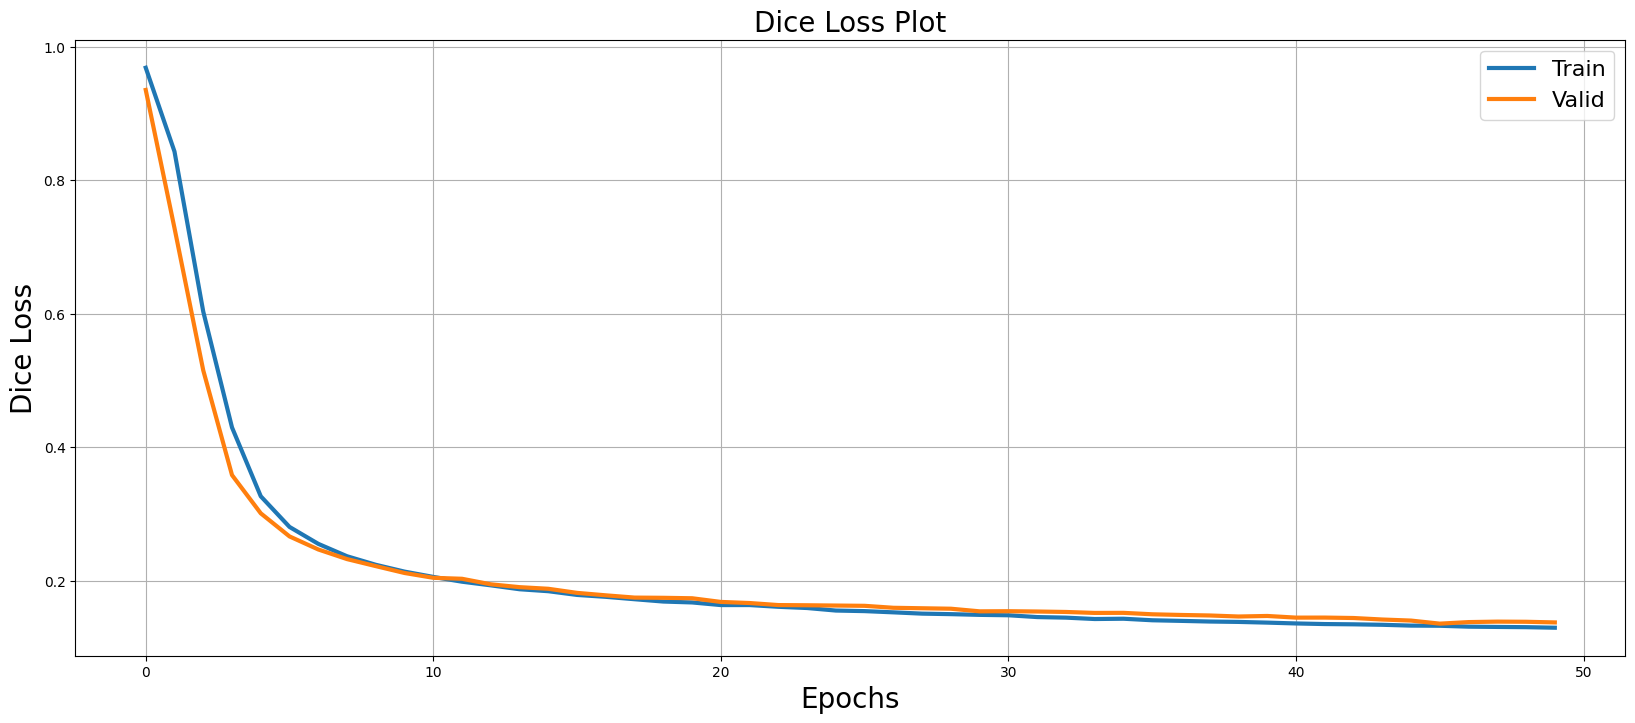

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()

## Plotting the training loss curves af all the four models used in the experiments.

In [3]:
import pandas as pd

unet = pd.read_csv('/content/drive/MyDrive/SAM2/train_logsnet_df (2).csv')
deeplab = pd.read_csv('/content/drive/MyDrive/SAM2/train_logsdeep_df.csv')
usam = pd.read_csv('/content/drive/MyDrive/SAM2/train_logsusamf_df.csv')
sam = pd.read_csv('/content/drive/MyDrive/SAM2/train_logssamf_df.csv')


In [ ]:
usam

In [4]:
unet_logs = unet['dice_loss'].tolist()
deeplab_logs = deeplab['dice_loss'].tolist()
usam_logs = usam['0'].tolist()
sam_logs = sam['0'].tolist()

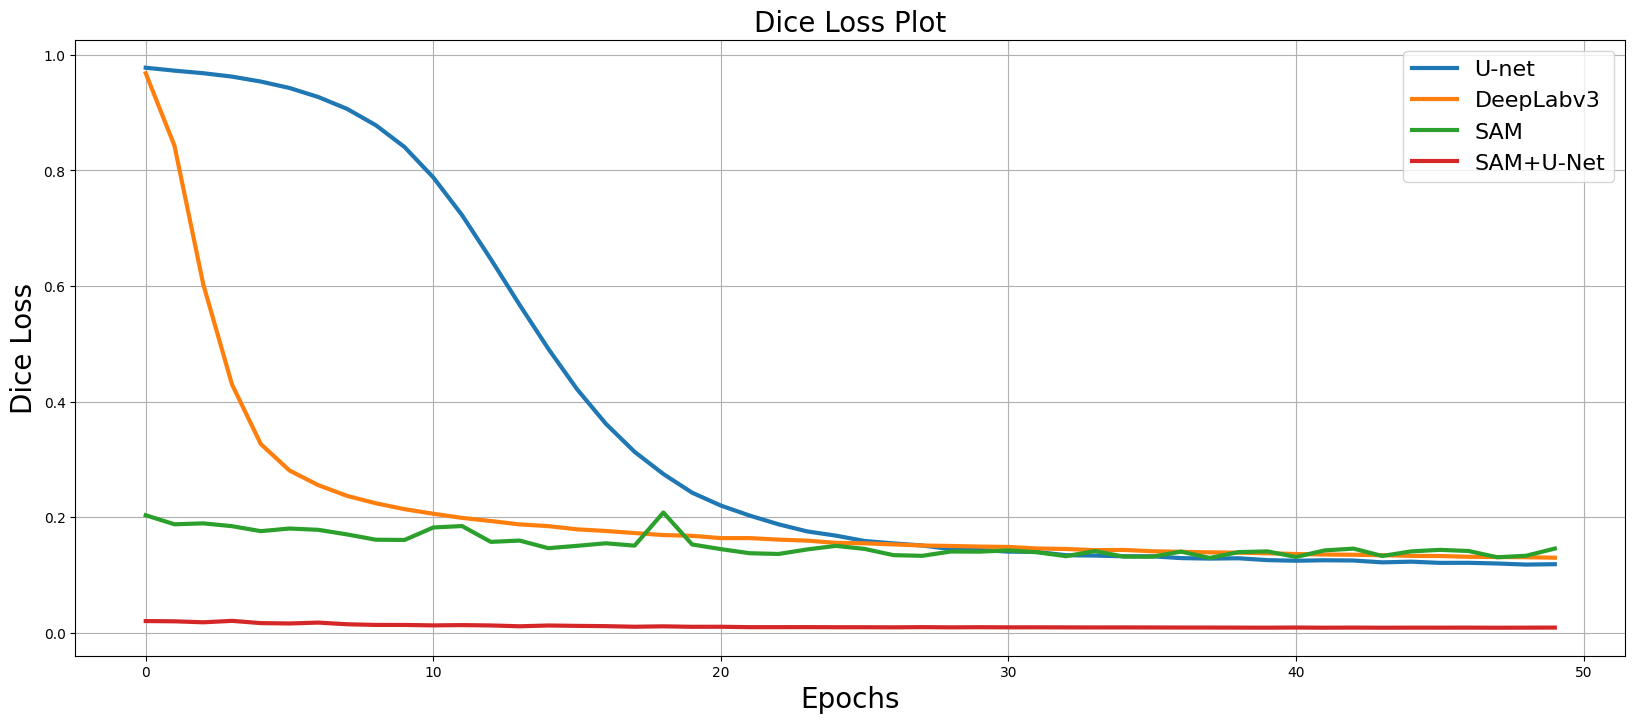

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,8))
plt.plot(unet.index.tolist(), unet_logs, lw=3, label = 'U-net')
plt.plot(deeplab.index.tolist(), deeplab_logs, lw=3, label = 'DeepLabv3')
plt.plot(sam.index.tolist(), sam_logs, lw=3, label = 'SAM')
plt.plot(usam.index.tolist(), usam_logs, lw=3, label = 'SAM+U-Net')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()